<a href="https://colab.research.google.com/github/anupampani123/PneumoniaDetectionEEHS/blob/main/PneumoniaDetectionEEHS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#X-ray Dataset 
#Using the kaggle API key, we first get the dataset 

from google.colab import files
files.upload()
!pip install -q kaggle 
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/ 
!kaggle datasets download paultimothymooney/chest-xray-pneumonia
!unzip -q /content/chest-xray-pneumonia.zip

Saving kaggle.json to kaggle.json
100% 2.28G/2.29G [00:37<00:00, 57.6MB/s]
100% 2.29G/2.29G [00:37<00:00, 65.9MB/s]


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
import numpy as np

In [ ]:
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Model

import numpy as np
from skimage import data, img_as_float
from skimage import exposure

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

input_path = '/content/chest_xray/'



# Model Trianing

In [ ]:
#Using the concept of transfer learning, we use a pretrained model called Xception which 
#uses 
img_dims = 224
batch_size = 32
model = Xception(include_top=False, input_shape=(img_dims, img_dims, 3),pooling='max')

In [ ]:
#Set the pre-trained layers to non trainable
for layer in model.layers:
	layer.trainable = False

In [ ]:
# i=0

# for layer in model.layers:
#     i=i+1
#     if(i<136):
#       layer.trainable = False
#     else :
#       layer.trainable = True


In [ ]:
# add new classifier layers



flatten = Flatten()(model.layers[-1].output)
Dense_layer1 = Dense(units = 256,activation='relu')(flatten)
Dense_layer2 = Dense(units=128,activation='relu')(Dense_layer1)
Dense_layer3 = Dense(units = 64,activation='relu')(Dense_layer2)
output_layer = Dense(1,activation='sigmoid')(Dense_layer3)
# define new model

model = Model(inputs=model.inputs, outputs=output_layer)




In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])



In [ ]:
# Preprocessing Function
import cv2
def apply_clahe(data):
  data = data/255
  return exposure.equalize_adapthist(data)




In [ ]:
train_datagen = ImageDataGenerator(
preprocessing_function=apply_clahe,
rotation_range=10,
rescale = 1./255,
shear_range = 0.2,
zoom_range = 0.2,
horizontal_flip = True)

# test_datagen = ImageDataGenerator(preprocessing_function=apply_clahe_skimage,
# rescale = 1./255,
# shear_range = 0.2,
# zoom_range = 0.2,
# horizontal_flip = True)

# valid_datagen= ImageDataGenerator(preprocessing_function=apply_clahe_skimage,
# rescale = 1./255,
# shear_range = 0.2,
# zoom_range = 0.2,
# horizontal_flip = True)


training_set = train_datagen.flow_from_directory(directory=input_path+'train',
target_size = (img_dims, img_dims),
batch_size = batch_size,
class_mode = 'binary')

validation_set = train_datagen.flow_from_directory(directory=input_path+'val',
target_size = (img_dims, img_dims),
batch_size = batch_size,
class_mode = 'binary')

test_set = train_datagen.flow_from_directory(directory=input_path+'test',
target_size = (img_dims, img_dims),
batch_size = batch_size,
shuffle=True,
class_mode = 'binary')

epochs = 15


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

callback_list = ModelCheckpoint('xception_model15epochs_file.h5', 
                                 monitor='val_accuracy', 
                                 verbose=True, 
                                 save_best_only=True)

In [ ]:
r = model.fit(
    training_set,
    epochs = epochs,
    validation_data = test_set,
    validation_steps = len(test_set),
    steps_per_epoch = 100,
    callbacks = [callback_list]
)

Epoch 1/15
100/100 [==============================] - 160s 2s/step - loss: 0.2766 - accuracy: 0.8750 - val_loss: 0.3996 - val_accuracy: 0.8269

Epoch 00001: val_accuracy improved from -inf to 0.82692, saving model to xception_model15epochs_file.h5
Epoch 2/15
100/100 [==============================] - 159s 2s/step - loss: 0.2726 - accuracy: 0.8750 - val_loss: 0.4322 - val_accuracy: 0.8061

Epoch 00002: val_accuracy did not improve from 0.82692
Epoch 3/15
100/100 [==============================] - 159s 2s/step - loss: 0.2698 - accuracy: 0.8769 - val_loss: 0.4063 - val_accuracy: 0.8285

Epoch 00003: val_accuracy improved from 0.82692 to 0.82853, saving model to xception_model15epochs_file.h5
Epoch 4/15
100/100 [==============================] - 159s 2s/step - loss: 0.2610 - accuracy: 0.8809 - val_loss: 0.6283 - val_accuracy: 0.7163

Epoch 00004: val_accuracy did not improve from 0.82853
Epoch 5/15
100/100 [==============================] - 158s 2s/step - loss: 0.2442 - accuracy: 0.8881 - 

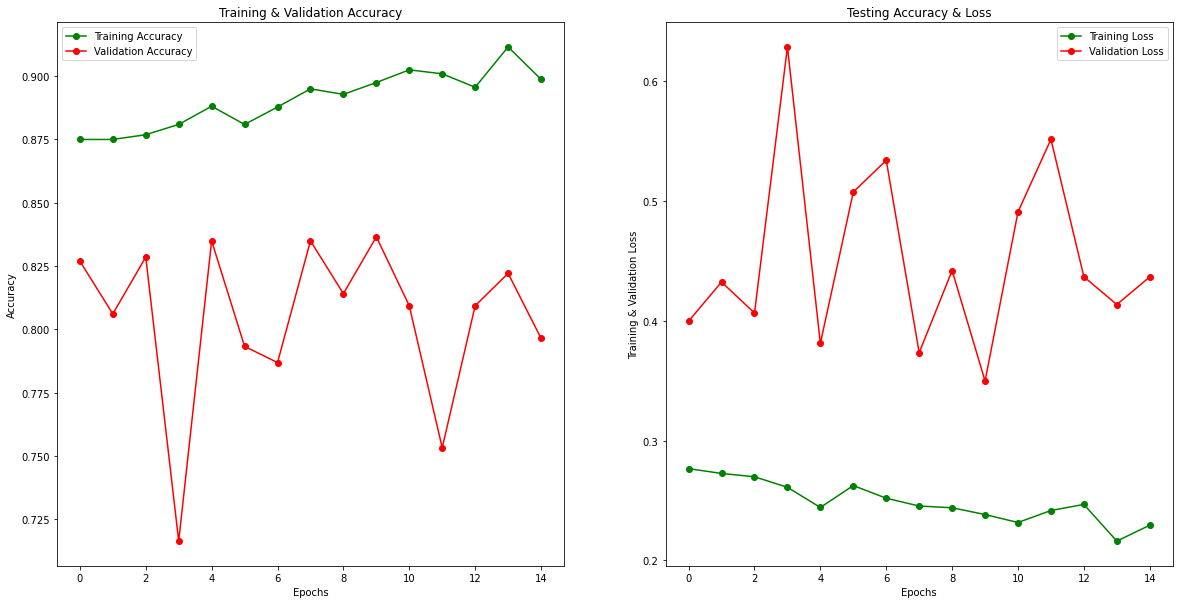

In [ ]:
import matplotlib.pyplot as plt
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = r.history['accuracy']
train_loss = r.history['loss']
val_acc = r.history['val_accuracy']
val_loss = r.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [ ]:
model.evaluate(test_set)

20/20 [==============================] - 25s 1s/step - loss: 0.3926 - accuracy: 0.8365


[0.39258548617362976, 0.8365384340286255]